# Info 3950 Problem Set "9"

**"due" Thu evening 27 May 2021 23:00**

### <font color='red'>YOUR NAME/NETID HERE</font>

# 1)  US Covid-19 fit

[ps5](https://nbviewer.jupyter.org/url/courses.cit.cornell.edu/info3950_2021sp/ps5.ipynb) problem 2 considered polynomial fits to the Covid-19 deaths data. That was not intended to be a principled fit in the absence of an underlying model.

This problem will cover a more principled model, namely the SIR (="Susceptible/Infectious/Recovered") model,
covered in section [21.3](https://www.cs.cornell.edu/home/kleinber/networks-book/networks-book-ch21.pdf) of the Easley/Kleinberg text used in Info 2040 (Networks). (Though ordinarily only sections 21.1-21.2 are covered in class, the entire chapter is worth reading.)

As in ps5, the data for this can be retrived from

    url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'

In [1]:
#you'll need
import matplotlib.pyplot as plt, numpy as np
%matplotlib inline

from scipy.optimize import curve_fit
from scipy.stats import norm

## A. UG

We'll start with a simplified version of this model, which can be called an "unlimited growth" model. It starts with some number of people infected, `Ni` and the daily infectivity rate `ki`, giving the average number of new infections per day caused by each infected person.  It is intended to model the initial spread, before the general population knows that Sars-Cov-2 is spreading in their area. Each day the number of new infections (the infection rate) is given by `Ri = ki * Ni`, and is then used to increment the total current infections `Ni`. (We are not yet considering that people can recover, or that the population is finite.)

In [2]:
def UG(x, ki, Ni):
    Ri_list = []
    for i in x:
        Ri = ki*Ni
        Ni += Ri
        Ri_list.append(Ri)
    return np.array(Ri_list)

We'll use this to model the 19 days of Covid-19 case data starting on 26 Feb 2020:

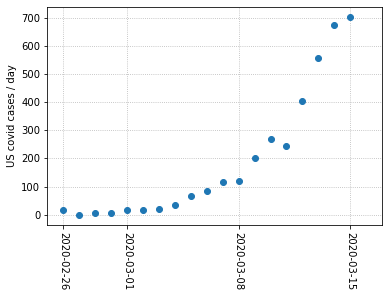

In [3]:
plt.plot(cases[35:35+19], 'o')
# ...

To fit this data, use [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html), as imported above. We can either choose some initial `Ni` and fit just `ki`, or we can fit both simultaneously, as here:

In [ ]:
# covs = covariances give error bars on parameters we won't be using
params,covs = curve_fit(UG, range(19), cases[35:35+19])
params

The first argument of `curve_fit` is the function to fit, the second is the `x` values to feed that function (as its first argument), and the third is the `y` values which are auto-fit by adjusting the additional parameters of the function.
You should find `ki` on the order of 1/4 (new infections per day per person infected), and `Ni` in the low 40s.
You can plot the fitted curve, using `UG(range(19),*params)`, and the fit curve together with the data should look something like:

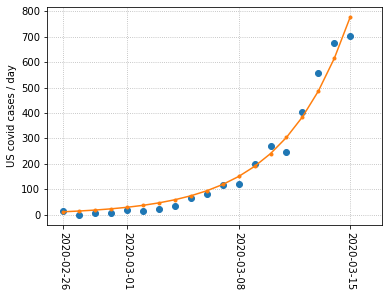

In [4]:
plt.plot(cases[35:35+19], 'o')
plt.plot(UG(range(19),*params), '.-')
#

## B. SI

Now we'll add the effect of a finite population `N`, to define an SI (susceptible/infected) model.
This means keeping track as well of the number `Ns = N - Ni` of those susceptible.

Starting from the `UG` function above, define a new function `SI(x, ki, Ni=1, N=1000)`, with `Ns` initialized as above (and updated in the loop after `Ni` is updated). The additional change is that new infections only occur within the fraction of the population that is susceptible, so now there's an additional final factor in the new infections per day: `Ri = ki*Ni *(Ns/N)`.

The disease propagates through the entire population, until everyone is infected. (Since no one ever 'recovers', everyone remains infectious.) The rate of propagation depends on the daily infectivity rate `ki`. To get some intuition, use the default population `N=1000`, and plot the new daily infections for `ki = .3` (no social distancing) and `.15` (some social distancing). It should look something like the below, where the smaller value of `ki` corresponds to a "flatten the curve" scenario.

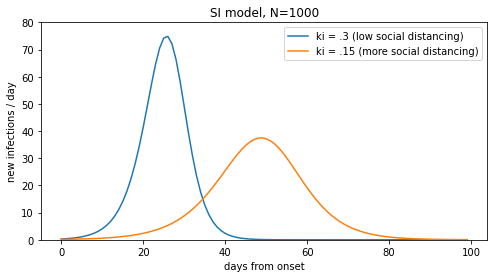

In [5]:
plt.figure(figsize=(8,4))
plt.plot(SI(range(100),.3), label='ki = .3 (low social distancing)')
plt.plot(SI(range(100),.15), label='ki = .15 (more social distancing)')
# ...

## C. SIR
The next element added to the model gives infected members of the population the ability to transition to a "recovered" state, in which they're no longer either susceptible or infectious. 
This involves a new rate constant, the daily recovery rate `kr`, giving the average likelihood of transitioning from infected to recovered per day. (Note that `1/kr` is then the mean recovery time in days, and the conventional `R0` in terms of these constants is given by `R0 = ki/kr`: the mean number of new infections per day times the mean number of days of infectivity. This therefore represents the mean total number infected by each individual while in the infectious state, at the beginning when the full population is susceptible.)

Define a new function `SIR(x, ki, Ni=1, N=1000)`, with the total number of recovered individuals starting as `Nr=0`.
The number of new recovered individuals per day is given by `Rr = kr*Ni`, and used to increment `Nr`. The total number infected `Ni` is now incremented by `Ri - Rr` (i.e., add the newly infected but remove the recovered), and the remaining susceptible is now given by `Ns = N - Ni - Nr`.

For this problem (only), you should also keep track of the running values of `Ni,Ns,Nr` through the simulation.
For values `ki=.12`, `kr=1/16`, and `N=1000`, they should look like this:

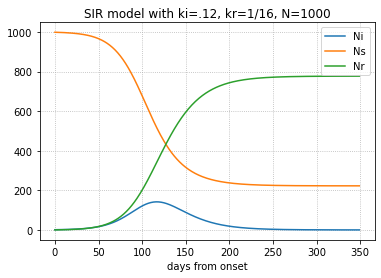

In [6]:
plt.plot(N_list, label='N')
plt.legend(['Ni','Ns','Nr'])
# ...

**Notes**

1) Note that the effect of social distancing, through reducing infection rate constant `ki`, will depend on its relation to the recovery time. For `ki=.12` and a shorter time to recover `1/kr=8` days, the product `R0=ki/kr` is less than 1, the infection never spreads and most of the population is unaffected; whereas for a larger time to recover `1/kr=32`, the infection spreads to the entire population.)

2) Note also in the above plot that the number of infectious `Ni` declines after the peak because the number of newly infected `Ri` is less than the number of newly recovered `Rr` -- that corresponds to what is known as "herd immunity".  The herd immunity threshold is the fraction `(Ni+Nr)/N = 1 - (Ns/N)` no longer susceptible at the peak.

3) The peak in `Ni` occurs when `Rr` increases to the point that `Ri=Rr` (after that `Rr` exceeds `Ri` and `Ni` decreases). Recalling that `Ri = ki * Ni * (Ns/N)`, and `Rr = kr * Ni`, the herd immunity threshold is given by `h = 1 - (Ns/N) = 1 - kr/ki = 1 - 1/R0`.

4) For `ki=.6` per day and `1/kr = 8` days, the average infected individual is responsible for `R0 = 4.8` new infections (no social distancing, everyone susceptible), and the herd immunity threshold `1 - 1/R0` is roughly 80% (i.e., in the range of current estimates).
That threshold is reduced when `ki` is reduced by social distancing, and technically whenever `Ri` is decreasing it means that the population is above the herd immunity threshold for the current value of `ki`.

5) For the remainder (D,E), you should use `kr=1/8` (1/16 was just for the plot above, but isn't the correct effective value for actual Covid-19)

## D. Gaussian transition functions

Since the data modeled here is national data, it is aggregated over many different locales, and in some time periods dominated by a few large population hot spots.
In practice, there has also been a small number of transitions between different policies of social distancing, school closure, mask requirements, remote work, and so on. These transitions can also be modeled as an effective average.

The question is how to take into account the spread in dates of implemention of those various measures in different places. A natural method is to assume a transition between two values of `ki`, say `k1` and `k2`, but the date of implementation in different locales is normally distributed with some mean and standard deviation, taken as parameters to be fit. That means that the cumulative probability of having transitioned from `k1` to `k2` is given by the cumulative distribution function of the normal distribution `norm.cdf()`, which can therefore be used to determine the weights of the weighted average of the two values, `k1 + (k2-k1)*norm.cdf(i,t12,s12)`. (Note that well below `t12` this takes the value `k1`, and well above takes the value `k2`.)

Here is an example of a `k1` to `k2` transition from .5 to .1, occurring on average at day `t12=20`, with a standard deviation of `s12=5`:

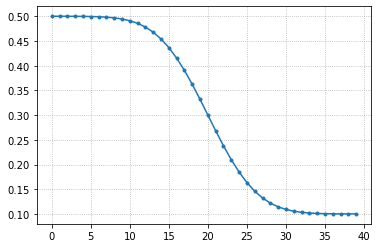

In [7]:
k1,k2 = .5,.1
t12,s12 = 20,5
ki = [k1 + (k2-k1)*norm.cdf(i,t12,s12) for i in range(40)]
plt.plot(ki,'.-')
plt.grid(ls=':');

Consider the data for the 90 days starting at 26 Feb 2020:

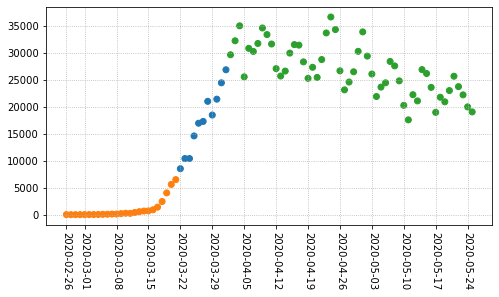

In [8]:
plt.figure(figsize=(8,4))
plt.scatter(range(90), cases[35:35+90], c=['C1']*25 + ['C0']*11 + ['C2']*54)
#...

During the month of March, different states implemented social distancing polices at different times, with the result that a large value of `ki` transitioned to a smaller value. You can now augment your `SIR` model to define a model `SIR_1t(x, Ni, k1, k2, t12, s12, N=8.25e7)` to fit the two values of `ki`, along with the transition mean `t12` and standard deviation `s12`, using the effective form of `ki` defined above.

Note: you should also use `kr=1/8` for the remainder of D and E

The values of the parameters can be fit using

    params1,cov1 = curve_fit(SIR_1t, range(90), cases[35:35+90],
                         bounds=([1, .1,.1, 5,5], [50, 1,1, 35,35])) # [lower], [upper] bounds

In the above, the bounds are used to constrain the five parameters to be within the region of interest. (When using bounds, it will not try to fit additional parameters, so will leave the default `N=8.25e7`.)

This may take 5-10 seconds to fit, and you should find values of `k1`, `k2` transitioning from around .8 to around .1, at a mean of about 21 days. Plot the above data, along with the `SIR_1t` output for those values. It should look something like:

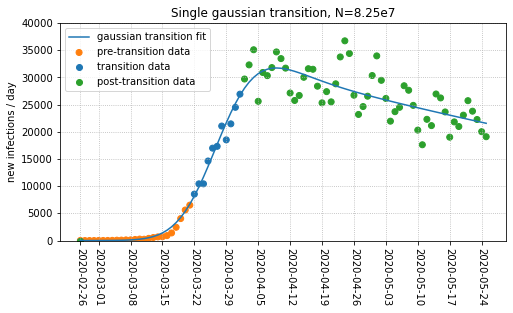

In [9]:
plt.figure(figsize=(8,4))
plt.plot(SIR_1t(range(90), *params1))
# ...

New York City implemented its mask wearing and social distancing rules on 22 Mar 2020. Estimate the number of lives that were lost in the US by Memorial Day (25 May 2020) because the rest of the country didn’t immediately follow New York City’s lead. To do this, you should use the earlier function `SIR` (no transitions) to fit the first 25 days of data (with `N=8.25 e7` and `kr=1/8`) to find the initial `Ni` and `ki`. Then use `SIR_1t` with a transition on 22 Mar 2020 (with a short standard deviation of 1 day) from that value of `ki` (around .525) to the final value of `ki` (around .12) found in the simulation just above.

Your `SIR_1t` will return a list of the number infected each day through 25 May 2020, which can be summed for the total number of infected. Subtract the sum for the sharp transition simulation from the sum from the transition fit with the optimal parameters to find the number of excess cases. Then multiply that number by .063 to estimate the number of excess deaths. (That number is based on the crude mortality ratio, given by dividing the total deaths data for the period 4 Mar - 1 Jun 2020 by the total cases reported 26 Feb - 25 May 2020. The ratio is high for that period because limited testing was only detecting about 10% of cases.)

The 22 Mar 2020 NYC shutdown was criticized as late at the time, since cases detected earlier in the month indicate the community spread was already occurring, and would lead to the inevitable exponential increase. Estimate by what percentage the total number of cases would have been reduced had NYC implemented its shutdown one week earlier, on 15 Mar 2020. (This can be estimated as above by comparing the `SIR` summed output for the 25 days starting at 26 Feb to the `SIR_1t` output with a sharp transition (standard deviation = 1) at 18 Mar 2020.)

## E.  Four transitions from 26 Feb 2020 - 27 Nov 2020

Now transition to the rest of the dataset, to reproduce the plot shown and discussed in the first 20 min of lec22 (see video). The data is as below (where the 7 day average is based on the three preceding, current, and three succeeding days, rather than the six preceding days, since we're looking at retrospective data). The data up to thanksgiving 2020 (27 Nov) will be used for the fit, and can be modeled with four `ki` transitions, as indicated.

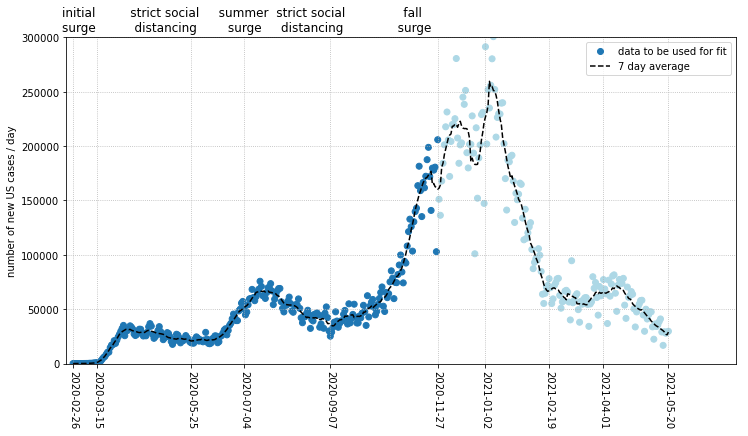

In [10]:
plt.figure(figsize=(12,6))
# ...

Define a function

    def SIR_4t(x,k1,k2,k3,k4,k5,  # infectivity rates
          t12,t23,t34,t45, # means of transitions
          s12,s34,s23,s45, # sigmas of transitions
          N=6.6e7, Rv=0):  # default population,    \#vaccinated (not used for fit)

with five values of `ki`, and four transitions with means `t12,...,t45` and standard deviations `s12,...,s45`.
Since these will be spread out (i.e., one transition will be completed before the next begins), you can use

    ki = k1 + (k2-k1)*norm.cdf(i,t12,s12) + (k3-k2)*norm.cdf(i,t23,s23)\
                       + (k4-k3)*norm.cdf(i,t34,s34) + (k5-k4)*norm.cdf(i,t45,s45)

for the effective time dependent `ki`.  The value of `N=6.6e7` is chosen to be about 20% of the population, since the [CDC estimates](https://web.archive.org/web/20210401182614/https://www.cdc.gov/coronavirus/2019-ncov/cases-updates/burden.html) for the period Feb-Dec 2020 that only about 1 in 4.6 cases was reported.

For this function you can use `Ni = 5` for the initial number infected, and continue to use `kr = 1/8`.
You can fit the parameters of the function using bounds as below, to place the transitions in the expected ranges suggested by the plot:

    params20, covs20 = curve_fit(SIR_4t, range(276), cases[35:35+276],
                    bounds=([.05]*5 + [10,  90, 125, 200] + [1.]*4,  #lower bounds
                              [1]*5 + [50, 130, 165, 240] + [30.]*4))  # upper bounds      

Since there are now 13 parameters to fit, this may take a bit longer to run (on the order of a minute or more, depending on your computer).

Plot your fit along with the data, but extrapolate your fit out to 500 days (starting from the 26 Feb 2020, so out to Jun 2021). You should find that the extrapolation predicts a form of herd immunity, i.e., with a January drop-off due not to any social distancing induced change in `ki`.

The additional element in the extrapolation is the vaccinations starting roughly 2 Jan 2021, described by the parameter `Rv` in the above (modeling the number of vaccinations per day). Starting on that date, the number of recovered `Nr` receives an additional increment by the fixed number `Rv`, since those individuals will no longer be susceptible.  With `Rv=100000`, you should find an even better agreement with the Jan 2021 through early Feb fall-off (and taking into account the factor of five population scaling used here, does correspond to the roughly 500,000 vaccinations per day given during that period).  Show that extrapolation on the plot as well, as in the plot shown in lecture 22.